In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'test', 'sample_submission', 'train', 'train.csv', 'sample_submission.csv']


# Exploratory Analysis

## Load the data

In [2]:
%%time
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

CPU times: user 6.41 s, sys: 952 ms, total: 7.36 s
Wall time: 7.38 s


In [3]:
print('Training set head')
display(df_train.head())
print('Test set head')
display(df_test.head())

Training set head


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Test set head


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


### *Some initial thoughts*

The `dropoff_datetime` column in the training frame is redundant, and can most likely be dropped at the **Feature Work** step. The target variable is therefore going to be `trip_duration`. 

In [4]:
print(df_train.isnull().values.any()) # Do we have any obvious missing training data (NaN)?
print(df_test.isnull().values.any()) # Do we have any obvious missing testing data (NaN)?

False
False


In [5]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134

(None, None)

Should probably cast the datetime columns identified as `object` type into `datetime64`.

In [6]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_train['dropoff_datetime'] = pd.to_datetime(df_train['dropoff_datetime'])

df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])

In [7]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 

(None, None)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


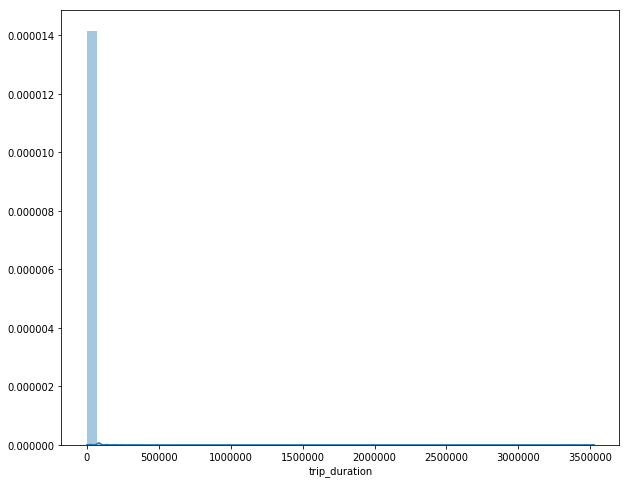

In [8]:
_, ax = plt.subplots(1, figsize=(10, 8))
sns.distplot(df_train['trip_duration'], ax=ax)

Seems very much like a log-normal distribution to me... There seems to be some outliers.

In [9]:
max_hrs = df_train['trip_duration'].max() // 3600
print('Max trip duration (hrs): {}'.format(max_hrs))

Max trip duration (hrs): 979


Are the non-outliers also in the form of a log-normal?

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


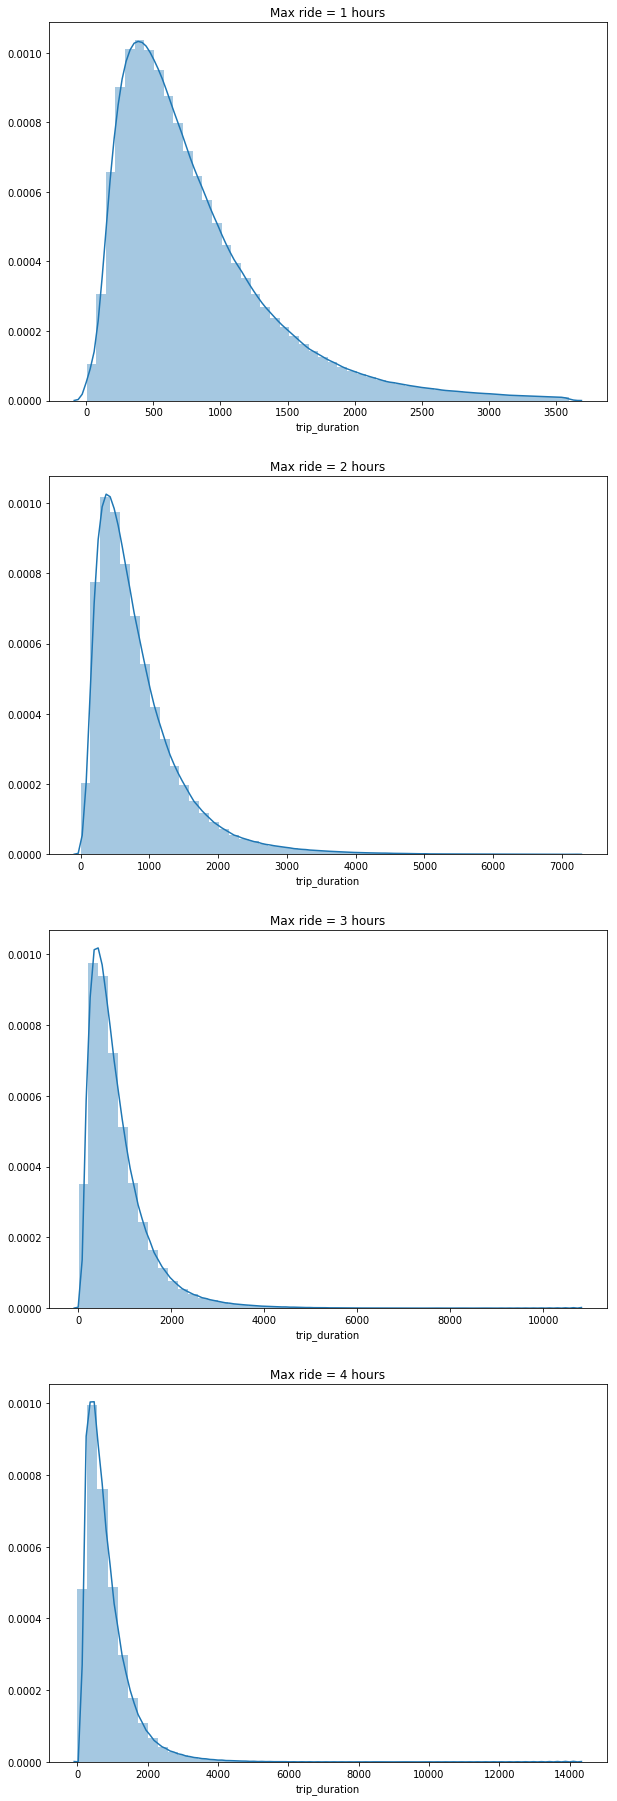

In [10]:
normals = [df_train.loc[df_train['trip_duration'] <= (i * 3600)]['trip_duration'] for i in range(1, 5)]

_, axes = plt.subplots(len(normals), figsize=(10, 8 * len(normals)))

for i, (normal, ax) in enumerate(zip(normals, axes)):
    ax.set_title('Max ride = {} hours'.format(i + 1))
    sns.distplot(normal, ax=ax)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


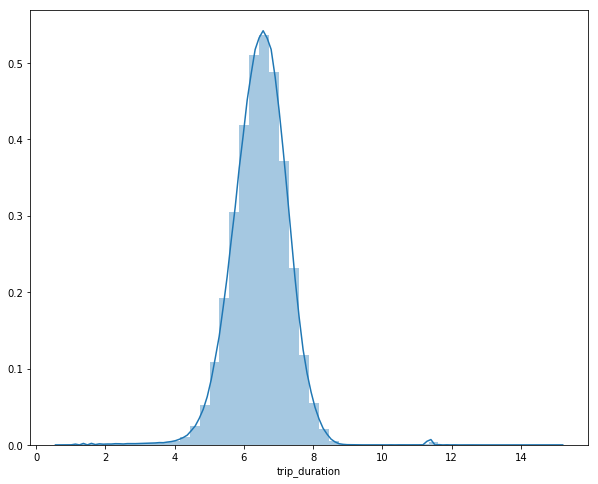

In [11]:
_, ax = plt.subplots(1, figsize=(10, 8))
sns.distplot(np.log(df_train['trip_duration'] + 1), ax=ax)

Much cleaner... Now we know we can log transform the target data in **Feature Work** section.

In [12]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## Feature Work

In [13]:
# make a copy of the training frame as a playground
def restore_train():
    return df_train.copy(deep=True)

train = restore_train()
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [14]:
def restore_test():
    return df_test.copy(deep=True)

test = restore_test()


In [15]:
pickup_hour = train['pickup_datetime'].dt.hour
pickup_dow = train['pickup_datetime'].dt.dayofweek
pickup_month = train['pickup_datetime'].dt.month
pickup_day = train['pickup_datetime'].dt.day

pickup_hour_test = test['pickup_datetime'].dt.hour
pickup_dow_test = test['pickup_datetime'].dt.dayofweek
pickup_month_test = test['pickup_datetime'].dt.month
pickup_day_test = test['pickup_datetime'].dt.day

train['pickup_datetime_hour'] = pickup_hour
train['pickup_datetime_dow'] = pickup_dow
train['pickup_datetime_month'] = pickup_month
train['pickup_datetime_day'] = pickup_day

test['pickup_datetime_hour'] = pickup_hour_test
test['pickup_datetime_dow'] = pickup_dow_test
test['pickup_datetime_month'] = pickup_month_test
test['pickup_datetime_day'] = pickup_day_test

display(train.head())
display(test.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,0,3,14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,2,4,6
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,5,3,26


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,23,3,6,30
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,23,3,6,30
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,23,3,6,30
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,23,3,6,30
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,23,3,6,30


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


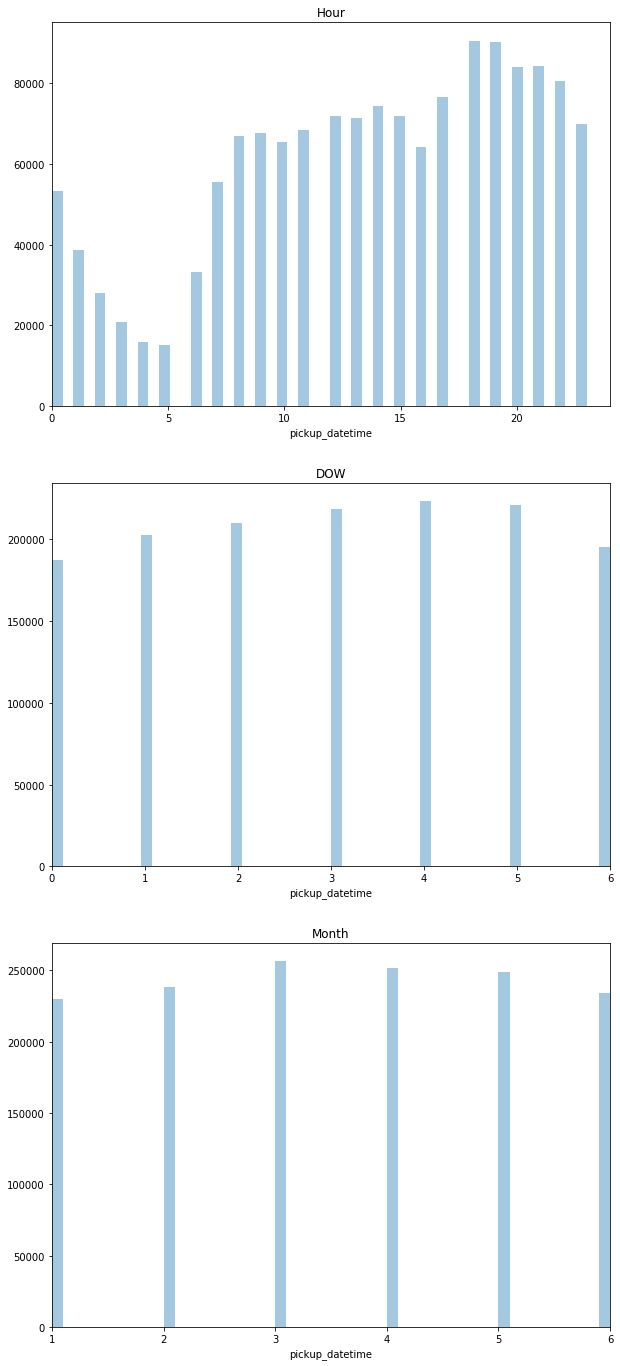

In [16]:
_, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 8*3))

ax0.set_xlim(left=0, right=24)
ax0.set_title('Hour')

ax1.set_xlim(left=0, right=6)
ax1.set_title('DOW')

ax2.set_xlim(left=pickup_month.value_counts().index.min(), 
             right=pickup_month.value_counts().index.max())
ax2.set_title('Month')

sns.distplot(pickup_hour, ax=ax0, kde=False)
sns.distplot(pickup_dow, ax=ax1, kde=False)
sns.distplot(pickup_month, ax=ax2, kde=False)

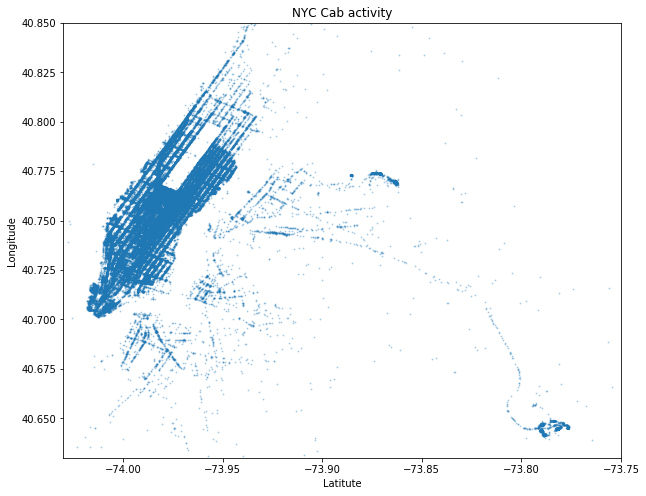

In [17]:
island_long_border = (-74.03, -73.75)
island_lat_border = (40.63, 40.85)

plt.figure(figsize=(10, 8))
plt.scatter(x=train.loc[:100000, 'pickup_longitude'], 
            y=train.loc[:100000, 'pickup_latitude'], s=1, alpha=0.25)
plt.title('NYC Cab activity')
plt.xlabel('Latitute')
plt.ylabel('Longitude')
plt.ylim(island_lat_border)
plt.xlim(island_long_border);

Pretty cool - we can see Central Park, and rides to LI and other off-Manhattan destinations.

A large concentration of fares are (obviously) in midtown/downtown, but also there is a pretty dense portion in LI.

In [18]:
def haversine_distance(lat_a, long_a, lat_b, long_b):
    '''Calculates the haversine distance between two geographic coordinates in meters.
    
    The haversine distance is defined as "the distance a crow flies" between two points.
    In the context of taxis in Manhattan, this distance metric makes less sense to use alone.
    
    The original winner posted a nice interpretation of the Manhattan distance using the
    haversine distance formula, and presented it as,
    
        L := Manhattan distance
        L(lat_a, long_a, lat_b, long_b) = 
            haversine_distance(lat_a, long_a, lat_a, long_b) +
            haversine_distance(lat_a, long_b, lat_b, long_a)
            
    We will implement this later in the notebook, but take it one small step further - we will only
    use L as the distance if the fare is in the bounds of Manhattan (aka downtown -> uptown).
    
    Parameters
    ----------
        lat_a  : latitude of point A (array-like)
        long_a : longitude of point A (array-like)
        lat_b  : latitude of point B  (array-like)
        long_b : longitude of point B (array-like)
    
    Returns
    -------
        the haversine distance between the two points
    '''
    
    def _to_radians(arr):
        return arr * np.pi / 180.
    
    
    def _a(del_lat, del_long, lat_a, lat_b):
        return (
            (np.sin(del_lat / 2) ** 2) +
            (np.cos(lat_a) * np.cos(lat_b) *
             np.sin(del_long / 2) ** 2)
        )
    
    
    def _c(a):
        return 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a));
    
    # radius of the earth in meters
    R = 6371e3
    
    lat_a_rad = _to_radians(lat_a)
    lat_b_rad = _to_radians(lat_a)
    long_a_rad = _to_radians(long_a)
    long_b_rad = _to_radians(long_b)
    
    del_lat_rad = _to_radians(lat_b - lat_a)
    del_long_rad = _to_radians(long_b - long_a)
    
    a = _a(del_lat_rad, del_long_rad, lat_a_rad, lat_b_rad)
    c = _c(a)
    
    return R * c

In [19]:
# test function on 10 points
lat_a = train.loc[:10, 'pickup_latitude'].values
long_a = train.loc[:10, 'pickup_longitude'].values
lat_b = train.loc[:10, 'dropoff_latitude'].values
long_b = train.loc[:10, 'dropoff_longitude'].values

print(haversine_distance(lat_a, long_a, lat_b, long_b))

[1498.4952482  1805.42755508 6384.7872194  1485.49606105 1188.58845126
 1098.97132894 1326.3222855  5714.21936804 1310.31063784 5121.1923897
 3805.97368363]


Seems to work. Let's time it on a larger portion of the data.

In [20]:
%%time

lat_a = train.loc[:100000, 'pickup_latitude'].values
long_a = train.loc[:100000, 'pickup_longitude'].values
lat_b = train.loc[:100000, 'dropoff_latitude'].values
long_b = train.loc[:100000, 'dropoff_longitude'].values

dists = haversine_distance(lat_a, long_a, lat_b, long_b)
print(dists)

[1498.4952482  1805.42755508 6384.7872194  ... 1823.2256024   743.71451521
  977.20568507]
CPU times: user 12 ms, sys: 12 ms, total: 24 ms
Wall time: 19.2 ms


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


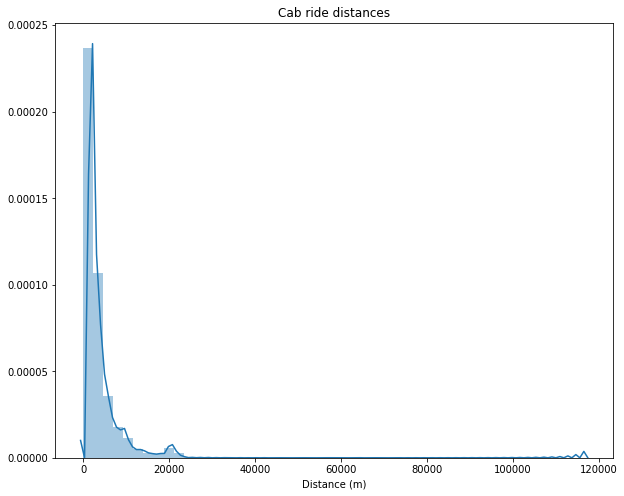

In [21]:
_, ax = plt.subplots(1, figsize=(10, 8))
ax.set_title('Cab ride distances')
ax.set_xlabel('Distance (m)')
sns.distplot(dists, ax=ax)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


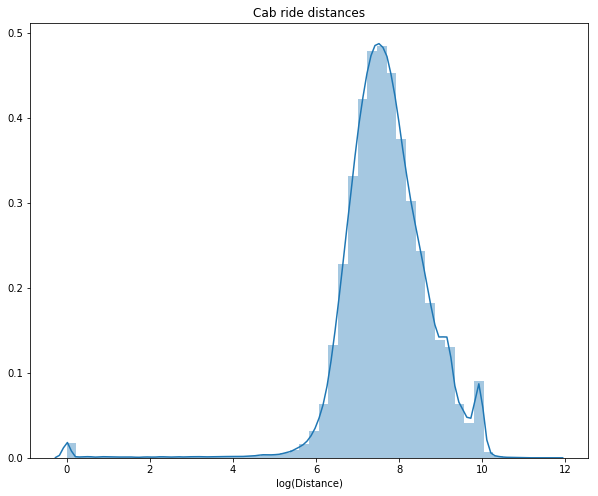

In [22]:
dists = np.log1p(dists)

_, ax = plt.subplots(1, figsize=(10, 8))
ax.set_title('Cab ride distances')
ax.set_xlabel('log(Distance)')
sns.distplot(dists, ax=ax)

In [23]:
def add_city_distance(rides):
    '''Calculates the "true" Manhattan distance between two geographic coordinates.
    
    This is probably a bad estimation of a city-block distance, but is better than nothing.
    
    Parameters
    ----------
        rides : the original data
    '''
    
    inbounds = rides.loc[(rides['pickup_longitude'] <= -73.94) & 
                         (rides['dropoff_longitude'] <= -73.94)]
    
    inbounds_idx = inbounds.index
    
    oob = rides.loc[~rides.index.isin(inbounds_idx), :]
    oob_idx = oob.index
    
    print('In-bounds rides: {}'.format(len(inbounds.index)))
    print('OOB rides: {}'.format(len(oob.index)))
    print('All rides accounted for: {}'.format(len(rides.index) == len(oob.index) + len(inbounds.index)))
    
    ib_lat_a = inbounds['pickup_latitude']
    ib_lat_b = inbounds['dropoff_latitude']
    ib_long_a = inbounds['pickup_longitude']
    ib_long_b = inbounds['dropoff_longitude']
    
    oob_lat_a = oob['pickup_latitude']
    oob_lat_b = oob['dropoff_latitude']
    oob_long_a = oob['pickup_longitude']
    oob_long_b = oob['dropoff_longitude']
    
    rides['city_distance'] = pd.Series(np.zeros(shape=(len(rides.index))), index=rides.index)
    rides.loc[inbounds_idx, 'city_distance'] = haversine_distance(ib_lat_a, ib_long_a, ib_lat_a, ib_long_b) + \
                                               haversine_distance(ib_lat_a, ib_long_a, ib_lat_b, ib_long_a)
    rides.loc[oob_idx, 'city_distance'] = haversine_distance(oob_lat_a, oob_long_a, oob_lat_b, oob_long_b)
    

In [24]:
def add_location_category(rides):
    '''Adds location category columns to the original data.
    
    Columns to add are dummy (one-hot) encoded variables
    indicating whether the start and end locations of the fare
    were in Downtown, Midtown, Uptown, or Other (off Manhattan)
    
     Parameters
    ----------
        rides : the original data
    '''
    
    island_long_max = -73.94
    
    # coordinates found using Google Maps
    downtown_lat_max = 40.73
    midtown_lat_max = 40.766
    
    OUT = 0 
    DOWNTOWN = 1
    MIDTOWN = 2
    UPTOWN = 3
    
    # Pickups
    
    downtown_pickup = rides.loc[(rides['pickup_longitude'] <= island_long_max) & (rides['pickup_latitude'] <= downtown_lat_max)]
    midtown_pickup = rides.loc[(rides['pickup_longitude'] <= island_long_max) & (rides['pickup_latitude'] > downtown_lat_max) & (rides['pickup_latitude'] <= midtown_lat_max)]
    uptown_pickup = rides.loc[(rides['pickup_longitude'] <= island_long_max) & (rides['pickup_latitude'] > midtown_lat_max)]
    
    oob_pickup = rides.loc[rides['pickup_longitude'] > island_long_max]
    
    # Drop offs
    
    downtown_dropoff = rides.loc[
        
            (rides['dropoff_longitude'] <= island_long_max) & 
            (rides['dropoff_latitude'] <= downtown_lat_max)
        
    ]
    midtown_dropoff = rides.loc[
        
            (rides['dropoff_longitude'] <= island_long_max) & 
            (rides['dropoff_latitude'] > downtown_lat_max) &
            (rides['dropoff_latitude'] <= midtown_lat_max)
        
    ]
        
    uptown_dropoff = rides.loc[
        
            (rides['dropoff_longitude'] <= island_long_max) & 
            (rides['dropoff_latitude'] > midtown_lat_max)
        
    ]
    
    oob_dropoff = rides.loc[rides['dropoff_longitude'] > island_long_max]
    
    rides['pickup_loc_category'] = pd.Series(dtype=np.int64, index=rides.index)
    rides['dropoff_loc_catetory'] = pd.Series(dtype=np.int64, index=rides.index)
    
    rides.loc[downtown_pickup.index, 'pickup_loc_category'] = DOWNTOWN
    rides.loc[midtown_pickup.index, 'pickup_loc_category'] = MIDTOWN
    rides.loc[uptown_pickup.index, 'pickup_loc_category'] = UPTOWN
    rides.loc[oob_pickup.index, 'pickup_loc_category'] = OUT
    
    rides.loc[downtown_dropoff.index, 'dropoff_loc_catetory'] = DOWNTOWN
    rides.loc[midtown_dropoff.index, 'dropoff_loc_catetory'] = MIDTOWN
    rides.loc[uptown_dropoff.index, 'dropoff_loc_catetory'] = UPTOWN
    rides.loc[oob_dropoff.index, 'dropoff_loc_catetory'] = OUT

In [25]:
%%time

add_city_distance(train)
add_city_distance(test)
display(train.head())
display(test.head())

In-bounds rides: 1287124
OOB rides: 171520
All rides accounted for: True
In-bounds rides: 552079
OOB rides: 73055
All rides accounted for: True


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,0,3,14,1735.433291
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,12,2430.506072
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,19,8203.575066
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,2,4,6,1661.331239
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,5,3,26,1199.456763


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,23,3,6,30,2913.303580
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,23,3,6,30,3104.805210
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,23,3,6,30,1846.340467
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,23,3,6,30,7163.346691
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,23,3,6,30,1354.163759


CPU times: user 2.28 s, sys: 688 ms, total: 2.97 s
Wall time: 2.19 s


In [26]:
%%time
add_location_category(train)
add_location_category(test)
display(train.head())
display(test.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance,pickup_loc_category,dropoff_loc_catetory
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,0,3,14,1735.433291,3,2
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,12,2430.506072,2,2
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,19,8203.575066,2,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,2,4,6,1661.331239,1,1
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,5,3,26,1199.456763,3,3


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance,pickup_loc_category,dropoff_loc_catetory
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,23,3,6,30,2913.303580,2,2
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,23,3,6,30,3104.805210,1,1
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,23,3,6,30,1846.340467,2,1
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,23,3,6,30,7163.346691,3,2
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,23,3,6,30,1354.163759,2,2


CPU times: user 1.52 s, sys: 384 ms, total: 1.9 s
Wall time: 1.9 s


Let's replace the categorical variables with a simple 1/0 flag.

In [27]:
train['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [28]:
train['vendor_id'] = train['vendor_id'] - 1
test['vendor_id'] = test['vendor_id'] - 1
display(train.head())
display(test.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance,pickup_loc_category,dropoff_loc_catetory
0,id2875421,1,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,0,3,14,1735.433291,3,2
1,id2377394,0,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,12,2430.506072,2,2
2,id3858529,1,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,19,8203.575066,2,1
3,id3504673,1,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,2,4,6,1661.331239,1,1
4,id2181028,1,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,5,3,26,1199.456763,3,3


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance,pickup_loc_category,dropoff_loc_catetory
0,id3004672,0,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,23,3,6,30,2913.303580,2,2
1,id3505355,0,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,23,3,6,30,3104.805210,1,1
2,id1217141,0,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,23,3,6,30,1846.340467,2,1
3,id2150126,1,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,23,3,6,30,7163.346691,3,2
4,id1598245,0,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,23,3,6,30,1354.163759,2,2


In [29]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [30]:
train['store_and_fwd_flag'] = (train['store_and_fwd_flag'] == 'Y').astype(np.int32)
test['store_and_fwd_flag'] = (test['store_and_fwd_flag'] == 'Y').astype(np.int32)
display(train.head())
display(test.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance,pickup_loc_category,dropoff_loc_catetory
0,id2875421,1,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,17,0,3,14,1735.433291,3,2
1,id2377394,0,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,0,6,6,12,2430.506072,2,2
2,id3858529,1,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,11,1,1,19,8203.575066,2,1
3,id3504673,1,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,19,2,4,6,1661.331239,1,1
4,id2181028,1,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,13,5,3,26,1199.456763,3,3


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance,pickup_loc_category,dropoff_loc_catetory
0,id3004672,0,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,23,3,6,30,2913.303580,2,2
1,id3505355,0,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,23,3,6,30,3104.805210,1,1
2,id1217141,0,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,23,3,6,30,1846.340467,2,1
3,id2150126,1,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,0,23,3,6,30,7163.346691,3,2
4,id1598245,0,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0,23,3,6,30,1354.163759,2,2


Pure latitude and longitude typically tend to be bad predictors. Let's do some unsupervised learning to try and find a better way to represent the latitude/longitude values. We can apply a clustering algorithm to split Manhattan into zones, using lat and long as clustering features.

In [31]:
def clustering_debug():
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    lat_long = train.loc[:, ['pickup_latitude', 'pickup_longitude']]
    lat_long.head()
    
    k = 7

    # Going to do some standard scaling
    scaler = StandardScaler()

    X_train, X_test = train_test_split(lat_long)

    # Keep original lat/longs for plotting purposes
    X_orig = X_train.copy(deep=True)

    # Replace longitude with positive values
    X_train.loc[:, 'pickup_longitude'] = X_train.loc[:, 'pickup_longitude'] * -1
    X_test.loc[:, 'pickup_longitude'] = X_test.loc[:, 'pickup_longitude'] * -1

    # Log-transform the data
    X_train, X_test = np.log(X_train), np.log(X_test)

    # Scale
    X_train = scaler.fit_transform(X_train)

    # Fit the KMeans model
    kmeans = KMeans(n_clusters=k)
    train_preds = kmeans.fit_predict(X_train)
    
    island_long_border = (-74.03, -73.75)
    island_lat_border = (40.63, 40.85)

    _, ax = plt.subplots(1, figsize=(10, 8))
    ax.scatter(X_orig.loc[:, 'pickup_longitude'].values[:100000],
               X_orig.loc[:, 'pickup_latitude'].values[:100000], 
               c=train_preds[:100000], s=1, alpha=1)
    ax.set_xlim(island_long_border)
    ax.set_ylim(island_lat_border);
    all_transformed = lat_long.copy(deep=True)
    all_transformed['pickup_longitude'] = all_transformed.loc[:, 'pickup_longitude'] * -1
    all_transformed = np.log(all_transformed)
    all_transformed = scaler.transform(all_transformed.values)
    all_transformed = pd.DataFrame(all_transformed, columns=lat_long.columns)
    display(all_transformed.head())
    print(all_transformed.shape)

    clustering_np = kmeans.predict(all_transformed)
    clustering = pd.Series(clustering_np)
    
    lat_long_test = test.loc[:, ['pickup_latitude', 'pickup_longitude']]
    all_transformed_test = lat_long.copy(deep=True)
    all_transformed_test['pickup_longitude'] = all_transformed_test.loc[:, 'pickup_longitude'] * -1
    all_transformed_test = np.log(all_transformed_test)
    all_transformed_test = scaler.transform(all_transformed_test.values)
    all_transformed_test = pd.DataFrame(all_transformed_test, columns=lat_long.columns)
    display(all_transformed_test.head())
    print(all_transformed_test.shape)

    clustering_np_test = kmeans.predict(all_transformed_test)
    clustering_test = pd.Series(clustering_np)
    
    train['location_cluster'] = clustering
    display(train.head())
    print(train['location_cluster'].value_counts())
    
    test['location_cluster'] = clustering_test
    display(test.head())
    print(test['location_cluster'].value_counts())


# Modeling

In [32]:
display(train.head())
display(test.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance,pickup_loc_category,dropoff_loc_catetory
0,id2875421,1,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,17,0,3,14,1735.433291,3,2
1,id2377394,0,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,0,6,6,12,2430.506072,2,2
2,id3858529,1,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,11,1,1,19,8203.575066,2,1
3,id3504673,1,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,19,2,4,6,1661.331239,1,1
4,id2181028,1,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,13,5,3,26,1199.456763,3,3


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance,pickup_loc_category,dropoff_loc_catetory
0,id3004672,0,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,23,3,6,30,2913.303580,2,2
1,id3505355,0,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,23,3,6,30,3104.805210,1,1
2,id1217141,0,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,23,3,6,30,1846.340467,2,1
3,id2150126,1,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,0,23,3,6,30,7163.346691,3,2
4,id1598245,0,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0,23,3,6,30,1354.163759,2,2


In [73]:
train_set = train.copy(deep=True)
test_set = test.copy(deep=True)

In [74]:
train_set.columns.values

array(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_datetime_hour', 'pickup_datetime_dow',
       'pickup_datetime_month', 'pickup_datetime_day', 'city_distance',
       'pickup_loc_category', 'dropoff_loc_catetory'], dtype=object)

Not all of these columns will be used for training, so we will drop the ones that aren't pertinent. First, we'll make the `id` column the dataframe index.

In [75]:
train_set.set_index('id', inplace=True)
train_set.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance,pickup_loc_category,dropoff_loc_catetory
id,,,,,,,,,,,,,,,,,
id2875421,1,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,17,0,3,14,1735.433291,3,2
id2377394,0,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,0,6,6,12,2430.506072,2,2
id3858529,1,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,11,1,1,19,8203.575066,2,1
id3504673,1,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,19,2,4,6,1661.331239,1,1
id2181028,1,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,13,5,3,26,1199.456763,3,3


In [36]:
#train_set = pd.concat([train_set, 
#            pd.get_dummies(train_set['vendor_id'], drop_first=True, prefix='vendor_id'),
#            pd.get_dummies(train_set['store_and_fwd_flag'], drop_first=True, prefix='store_and_fwd_flag'),
#            pd.get_dummies(train_set['pickup_loc_category'], drop_first=True, prefix='pickup_loc_category'),
#            pd.get_dummies(train_set['dropoff_loc_catetory'], drop_first=True, prefix='dropoff_loc_category')], axis=1)
#train_set.head()

In [76]:
train_set.drop(['dropoff_datetime', 'pickup_datetime', 
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude'], 
               axis=1, inplace=True)
print(train_set.columns.values)
display(train_set.head())

['vendor_id' 'passenger_count' 'store_and_fwd_flag' 'trip_duration'
 'pickup_datetime_hour' 'pickup_datetime_dow' 'pickup_datetime_month'
 'pickup_datetime_day' 'city_distance' 'pickup_loc_category'
 'dropoff_loc_catetory']


,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance,pickup_loc_category,dropoff_loc_catetory
id,,,,,,,,,,,
id2875421,1,1,0,455,17,0,3,14,1735.433291,3,2
id2377394,0,1,0,663,0,6,6,12,2430.506072,2,2
id3858529,1,1,0,2124,11,1,1,19,8203.575066,2,1
id3504673,1,1,0,429,19,2,4,6,1661.331239,1,1
id2181028,1,1,0,435,13,5,3,26,1199.456763,3,3


In [38]:
#test_set = pd.concat([test_set, 
#            pd.get_dummies(test_set['vendor_id'], drop_first=True, prefix='vendor_id'),
#            pd.get_dummies(test_set['store_and_fwd_flag'], drop_first=True, prefix='store_and_fwd_flag'),
#            pd.get_dummies(test_set['pickup_loc_category'], drop_first=True, prefix='pickup_loc_category'),
#            pd.get_dummies(test_set['dropoff_loc_catetory'], drop_first=True, prefix='dropoff_loc_category')], axis=1)
#test_set.head()

In [77]:
test_set.set_index('id', inplace=True)
test_set.drop([ 'pickup_datetime', 
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude',
                'dropoff_latitude'], 
               axis=1, inplace=True)

print(test_set.columns.values)
display(test_set.head())

['vendor_id' 'passenger_count' 'store_and_fwd_flag' 'pickup_datetime_hour'
 'pickup_datetime_dow' 'pickup_datetime_month' 'pickup_datetime_day'
 'city_distance' 'pickup_loc_category' 'dropoff_loc_catetory']


,vendor_id,passenger_count,store_and_fwd_flag,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance,pickup_loc_category,dropoff_loc_catetory
id,,,,,,,,,,
id3004672,0,1,0,23,3,6,30,2913.303580,2,2
id3505355,0,1,0,23,3,6,30,3104.805210,1,1
id1217141,0,1,0,23,3,6,30,1846.340467,2,1
id2150126,1,1,0,23,3,6,30,7163.346691,3,2
id1598245,0,1,0,23,3,6,30,1354.163759,2,2


In [78]:
train_set['pickup_datetime_day'] = train.pickup_datetime.dt.day.values
train_set['pickup_datetime_month'] = train.pickup_datetime.dt.month.values

In [79]:
test_set['pickup_datetime_day'] = test.pickup_datetime.dt.day.values
test_set['pickup_datetime_month'] = test.pickup_datetime.dt.month.values

In [80]:
train_set.shape[1] - 1 == test_set.shape[1] # make sure columns match

True

In [81]:
X_train = train_set.drop('trip_duration', axis=1)
y_train = train_set['trip_duration']

display(X_train.head())

,vendor_id,passenger_count,store_and_fwd_flag,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance,pickup_loc_category,dropoff_loc_catetory
id,,,,,,,,,,
id2875421,1,1,0,17,0,3,14,1735.433291,3,2
id2377394,0,1,0,0,6,6,12,2430.506072,2,2
id3858529,1,1,0,11,1,1,19,8203.575066,2,1
id3504673,1,1,0,19,2,4,6,1661.331239,1,1
id2181028,1,1,0,13,5,3,26,1199.456763,3,3


In [82]:
y_train = np.log1p(y_train)

In [45]:
#%%time
#estimator = RandomForestRegressor(n_estimators=25, max_depth=20, n_jobs=-1)
#cv_scores = cross_val_score(estimator,
#                            X_train,
#                            y=y_train,
#                            n_jobs=-1,
#                            scoring='neg_mean_squared_error')
#print('CV scores: {}'.format(cv_scores))

# estimator.fit(X_train, y_train)

**SCORE: 0.50390**

## Iteration 2

In [46]:
#display(X_train.head())
#display(test_set.head())

In [47]:
#X_train['city_distance'] = np.log1p(X_train.loc[:, 'city_distance'] / 1000)
#test_set['city_distance'] = np.log1p(test_set.loc[:, 'city_distance'] / 1000)

In [48]:
#X_train.head()

In [49]:
#%%time

#estimator = RandomForestRegressor(n_estimators=250, max_depth=15, n_jobs=-1)

# estimator.fit(X_train, y_train)

# it3_train_preds = estimator.predict(X_train)
#print(-1 * mean_squared_error(y_train, it3_train_preds))

# it3preds = estimator.predict(test_set)

**SCORE: 0.49037**

## Iteration 3

In [50]:
from sklearn.ensemble import GradientBoostingRegressor

In [51]:
#train.head()

In [52]:
#X_train.head()

In [53]:
#display(train_set.head())
#display(test_set.head())

In [54]:
#X_train.head()

In [55]:
#xgb_train = xgb.DMatrix(X_train, label=y_train)
#xgb_test = xgb.DMatrix(test_set)
#xgb_params_1 = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 20,
#                'subsample': 0.8, 'lambda': 1., 'booster' : 'dart', 'silent': 1,
#                'eval_metric': 'rmse', 'objective': 'reg:linear'}
#watchlist = watchlist = [(xgb_train, 'train')]

In [56]:
#xgb_estimator_1 = xgb.train(xgb_params_1, xgb_train, 60, watchlist, early_stopping_rounds=50,
#                          maximize=False, verbose_eval=10)

In [57]:
#xgb_params_2 = {'min_child_weight': 20, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
                #'subsample': 0.8, 'colsample_bytree': 0.8, 'lambda': 0.5, 'booster' : 'gbtree', 'silent': 1,
                #'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [58]:
#xgb_estimator_2 = xgb.train(xgb_params_2, xgb_train, 100, watchlist, early_stopping_rounds=50,
#                              maximize=False, verbose_eval=10)

In [59]:
#it4_preds = xgb_estimator_2.predict(xgb_test)

## Iteration 4

In [60]:
#%%time
#estimator = GradientBoostingRegressor(loss='huber', n_estimators=250)

#estimator.fit(X_train, y_train)

#it5_preds = estimator.predict(test_set)

## Iteration 5

In [61]:
#xgb_params_5 = {'min_child_weight': 15, 'eta': 0.2, 'colsample_bytree': 0.5, 'max_depth': 20,
#                'subsample': 0.8, 'lambda': 0.1, 'booster' : 'gbtree', 'silent': 1,
#                'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [62]:
#xgb_train = xgb.DMatrix(X_train, label=y_train)
#xgb_test = xgb.DMatrix(test_set)
#watchlist = [(xgb_train, 'train')]

In [63]:
#xgb_estimator_5 = xgb.train(xgb_params_5, xgb_train, 100, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)

In [64]:
#xgb5_preds = xgb_estimator_5.predict(xgb_test)

NameError: name 'xgb_estimator_5' is not defined

**SCORE: 0.47**

## Iteration 6

In [65]:
from catboost import CatBoostRegressor, Pool

In [84]:
test_set.head()

,vendor_id,passenger_count,store_and_fwd_flag,pickup_datetime_hour,pickup_datetime_dow,pickup_datetime_month,pickup_datetime_day,city_distance,pickup_loc_category,dropoff_loc_catetory
id,,,,,,,,,,
id3004672,0,1,0,23,3,6,30,2913.303580,2,2
id3505355,0,1,0,23,3,6,30,3104.805210,1,1
id1217141,0,1,0,23,3,6,30,1846.340467,2,1
id2150126,1,1,0,23,3,6,30,7163.346691,3,2
id1598245,0,1,0,23,3,6,30,1354.163759,2,2


In [85]:
cat_cols = [0, 2, 8, 9]

train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(test_set, cat_features=cat_cols)

cb_estimator = CatBoostRegressor(iterations=250, learning_rate=0.3, depth=10, loss_function='RMSE')
cb_estimator.fit(train_pool)

0:	learn: 4.5829460	total: 620ms	remaining: 2m 34s
1:	learn: 3.2313729	total: 1.74s	remaining: 3m 35s
2:	learn: 2.2947340	total: 2.33s	remaining: 3m 11s
3:	learn: 1.6479660	total: 3.39s	remaining: 3m 28s
4:	learn: 1.2068653	total: 4.43s	remaining: 3m 37s
5:	learn: 0.9160635	total: 5.45s	remaining: 3m 41s
6:	learn: 0.7315377	total: 6.39s	remaining: 3m 41s
7:	learn: 0.6186503	total: 7.4s	remaining: 3m 43s
8:	learn: 0.5561451	total: 7.71s	remaining: 3m 26s
9:	learn: 0.5173726	total: 8.68s	remaining: 3m 28s
10:	learn: 0.4949458	total: 9.53s	remaining: 3m 27s
11:	learn: 0.4827004	total: 10.4s	remaining: 3m 25s
12:	learn: 0.4760291	total: 11.2s	remaining: 3m 24s
13:	learn: 0.4717969	total: 12.2s	remaining: 3m 24s
14:	learn: 0.4692993	total: 13.2s	remaining: 3m 26s
15:	learn: 0.4676512	total: 14s	remaining: 3m 25s
16:	learn: 0.4661787	total: 15s	remaining: 3m 26s
17:	learn: 0.4653876	total: 16s	remaining: 3m 26s
18:	learn: 0.4643888	total: 16.9s	remaining: 3m 24s
19:	learn: 0.4635729	total: 1

157:	learn: 0.4442591	total: 2m 27s	remaining: 1m 25s
158:	learn: 0.4442182	total: 2m 28s	remaining: 1m 24s
159:	learn: 0.4441439	total: 2m 29s	remaining: 1m 23s
160:	learn: 0.4440960	total: 2m 30s	remaining: 1m 22s
161:	learn: 0.4439897	total: 2m 31s	remaining: 1m 22s
162:	learn: 0.4438761	total: 2m 32s	remaining: 1m 21s
163:	learn: 0.4437931	total: 2m 33s	remaining: 1m 20s
164:	learn: 0.4437697	total: 2m 34s	remaining: 1m 19s
165:	learn: 0.4437418	total: 2m 34s	remaining: 1m 18s
166:	learn: 0.4436519	total: 2m 36s	remaining: 1m 17s
167:	learn: 0.4435977	total: 2m 36s	remaining: 1m 16s
168:	learn: 0.4435746	total: 2m 37s	remaining: 1m 15s
169:	learn: 0.4434728	total: 2m 38s	remaining: 1m 14s
170:	learn: 0.4434237	total: 2m 39s	remaining: 1m 13s
171:	learn: 0.4433264	total: 2m 40s	remaining: 1m 12s
172:	learn: 0.4432934	total: 2m 41s	remaining: 1m 11s
173:	learn: 0.4431940	total: 2m 42s	remaining: 1m 11s
174:	learn: 0.4431080	total: 2m 43s	remaining: 1m 10s
175:	learn: 0.4430470	total:

In [86]:
cb_preds = cb_estimator.predict(test_pool)

# Submission

## Base model submission

Let's submit the `RandomForestRegressor` and see the score it obtains on the test data.

In [ ]:
#preds_raw = estimator.predict(test_set)
#preds = np.expm1(preds_raw)
#preds_df = pd.DataFrame(preds, index=test_set.index)
#preds_df.head()

In [ ]:
#preds_df.columns = ['trip_duration']
#preds_df.head()

In [ ]:
#preds_df.to_csv('rf_regressor.csv')
#pd.read_csv('rf_regressor.csv').head()

**SCORE: 0.50390**

## Iteration 2

In [ ]:
#it3preds_df = pd.DataFrame(np.expm1(it3preds), index=test_set.index)
#it3preds_df.columns = ['trip_duration']
#display(it3preds_df.head())

#it3preds_df.to_csv('rf_regressor.csv')
#pd.read_csv('rf_regressor.csv').head()

**SCORE: 0.49037**

## Iteration 3

In [ ]:
#it4preds_df = pd.DataFrame(np.expm1(it4_preds), index=test_set.index)
#it4preds_df.columns = ['trip_duration']
#display(it4preds_df.head())

#it4preds_df.to_csv('rf_regressor.csv')
#pd.read_csv('rf_regressor.csv').head()

**SCORE: 0.48758**

## Iteration 4

In [ ]:
#it5preds_df = pd.DataFrame(np.expm1(it5_preds), index=test_set.index)
#it5preds_df.columns = ['trip_duration']
#display(it5preds_df.head())

#it5preds_df.to_csv('rf_regressor.csv')
#pd.read_csv('rf_regressor.csv').head()

## Iteration 5

In [ ]:
#xgb5_preds_df = pd.DataFrame(np.expm1(xgb5_preds), index=test_set.index)
#xgb5_preds_df.columns = ['trip_duration']
#display(xgb5_preds_df.head())

#xgb5_preds_df.to_csv('rf_regressor.csv')
#pd.read_csv('rf_regressor.csv').head()

## Iteration 6

In [ ]:
cb_preds_df = pd.DataFrame(np.expm1(cb_preds), index=test_set.index)
cb_preds_df.columns = ['trip_duration']
display(cb_preds_df.head())

cb_preds_df.to_csv('rf_regressor.csv')
pd.read_csv('rf_regressor.csv').head()